## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
PATH = '/home/paperspace/data/planet/'

In [4]:
!ls {PATH}

__MACOSX		  test-jpg		    tmp
models			  test-jpg-additional	    train-jpg
sample_submission_v2.csv  test_v2_file_mapping.csv  train_v2.csv


In [4]:
# Data preparation steps if you are using Crestle:

os.makedirs('data/planet/models', exist_ok=True)
os.makedirs('/cache/planet/tmp', exist_ok=True)

!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
!ln -s /cache/planet/tmp {PATH}

## Multi-label versus single-label classification

In [5]:
from fastai.plots import *

In [6]:
def get_1st(path): return glob(f'{path}/*.*')[0]

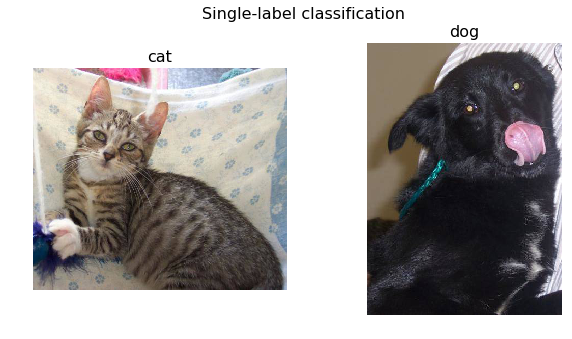

In [9]:
dc_path = "/home/paperspace/data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

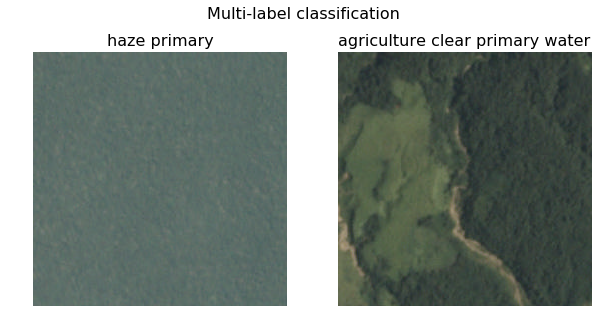

In [10]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [47]:
from planet import f2

metrics=[f2]
f_model = resnet34

In [126]:
label_csv = f'{PATH}train_v2.csv'
# how many images are in the train set
n = len(list(open(label_csv)))-6
# grab validation indexes
val_idxs = get_cv_idxs(n)

In [127]:
len(val_idxs), n-len(val_idxs)

(8094, 32380)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [128]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [129]:
data = get_data(256)

Standart `Python` things: `iter`, `next`

In [16]:
# returns the images in the minibatch and labels in the minibatch
x,y = next(iter(data.trn_dl))

In [17]:
y.shape

torch.Size([64, 17])

In [18]:
# one minibatch of labels
y


    1     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

* 64 - default size of a minibath
* 17 - number of classes

again standart Python things: `zip`, `list`

In [19]:
list(zip(data.classes, y[5]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 0.0)]

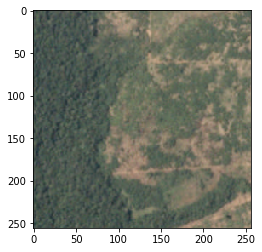

In [39]:
# *1.4 - to make it more visible if it's a bit washed out
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [130]:
sz=64

I'd not start with 64 size for cata&dogs competition because it starts nearly perfect. So if we resize everithing to 64x64 - we just through away the weights that have been already very good.

On the other hand the only useful layers in ImageNet for us are lower level, and there is nothing in high-level ImageNet features like in satellite images, so training on satellite at 64 makes sense.

In [131]:
data = get_data(sz)

In [132]:
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

So, all .resize() does is says: I'm not gonna be using any images bigger than sz*1.3. So go through once and create new jpegs of this size. And they are rectangular, so new jpegs with the smallest edge of this size

It's just a speed up. But if you have really big images coming in it saves you a lot of time

In [133]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

In [134]:
learn.summary()

ValueError: Expected more than 1 value per channel when training, got input size [1, 1024]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.21859    0.342004   0.827782  

CPU times: user 43.1 s, sys: 17 s, total: 1min
Wall time: 38.7 s


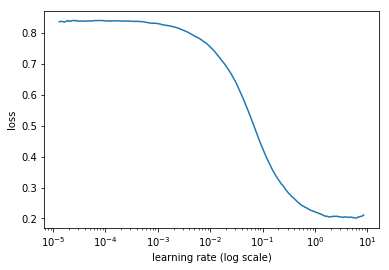

In [16]:
%%time
lrf=learn.lr_find()
learn.sched.plot()

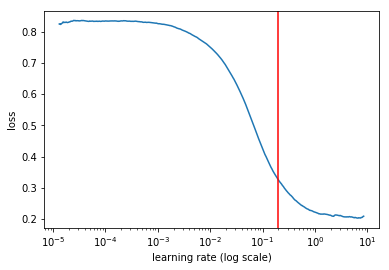

In [34]:
learn.sched.plot()
plt.axvline(x=2e-1, color="red");

For some reason here we can use super high learning rate, so we'll use `0.2`

In [35]:
lr = 0.2

Turns out I have to do a bit more training cause images are very different from ImageNet

In [36]:
%%time
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.148442   0.134355   0.882039  
    1      0.14209    0.128798   0.889253                    
    2      0.14003    0.127027   0.891037                    
    3      0.139798   0.12763    0.887921                    
    4      0.134339   0.125565   0.890314                    
    5      0.131021   0.123249   0.893564                    
    6      0.13151    0.123206   0.893189                    

CPU times: user 4min 58s, sys: 1min 26s, total: 6min 24s
Wall time: 4min 14s


[0.123206265, 0.8931889026492685]

*Took 4 minutes.*

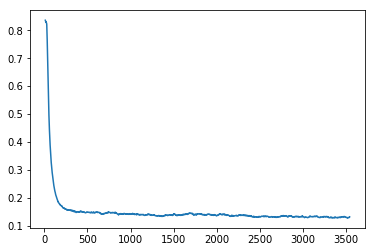

In [41]:
learn.sched.plot_loss()

Dataset is very different from ImageNet, that why we'd train those middle layers a bit more. So'd devide by 3 rather then by 10

In [37]:
lrs = np.array([lr/9,lr/3,lr])

In [38]:
%%time
learn.unfreeze()
#learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.22 ms


*Took 10 minutes.*

In [35]:
learn.save(f'{sz}')

In [39]:
learn.load(f'{sz}')

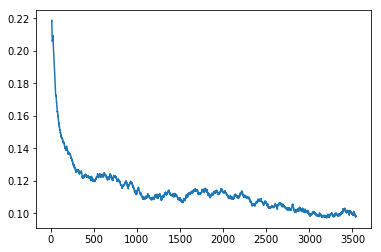

In [36]:
learn.sched.plot_loss()

Can kinda see: cycle 1, cycle 2, cycle 3

In [42]:
sz=128

In [43]:
%%time
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.097915   0.096655   0.916804  
    1      0.097379   0.095579   0.917289                     
    2      0.096367   0.094628   0.91895                      
    3      0.09886    0.094254   0.91931                      
    4      0.098765   0.094027   0.919359                     
    5      0.095416   0.093461   0.919762                     
    6      0.096076   0.093113   0.920876                     

CPU times: user 18min 25s, sys: 2min 22s, total: 20min 47s
Wall time: 7min 50s


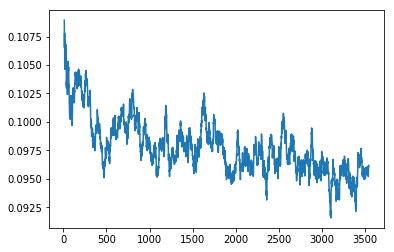

In [44]:
learn.sched.plot_loss()

In [45]:
%%time
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.093068   0.087696   0.927532  
    1      0.091485   0.088146   0.928225                     
    2      0.089031   0.085963   0.928004                     
    3      0.091689   0.087608   0.927005                     
    4      0.08954    0.086679   0.927184                     
    5      0.083523   0.08472    0.930003                     
    6      0.081942   0.08483    0.929041                     

CPU times: user 29min 1s, sys: 4min 54s, total: 33min 55s
Wall time: 21min 21s


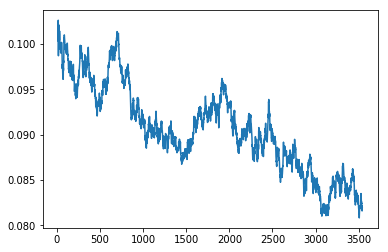

In [46]:
learn.sched.plot_loss()

In [23]:
sz=256

In [47]:
%%time
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.082708   0.084791   0.93005   
    1      0.083502   0.08519    0.92802                      
    2      0.079652   0.084701   0.929563                     
    3      0.083383   0.085411   0.92814                      
    4      0.07992    0.08463    0.929875                     
    5      0.082717   0.084524   0.929443                     
    6      0.081689   0.084704   0.929457                     

CPU times: user 18min 22s, sys: 2min 21s, total: 20min 43s
Wall time: 7min 50s


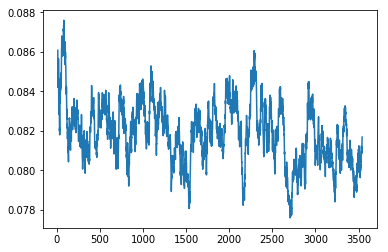

In [48]:
learn.sched.plot_loss()

In [49]:
%%time
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.085708   0.084272   0.931185  
    1      0.086268   0.0858     0.929403                     
    2      0.082603   0.083877   0.930866                     
    3      0.086623   0.087078   0.927188                     
    4      0.084364   0.085614   0.928399                     
    5      0.080372   0.084832   0.929536                     
    6      0.079924   0.084242   0.930443                     

CPU times: user 29min 3s, sys: 4min 51s, total: 33min 55s
Wall time: 21min 21s


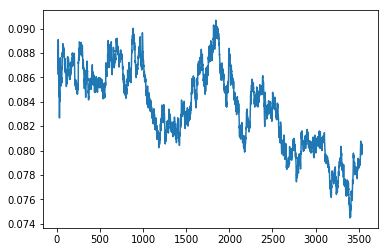

In [50]:
learn.sched.plot_loss()

In [51]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [52]:
f2(preds,y)

0.9291950817142282

### End

## Predict & Submit

In [ ]:
%%time
log_preds_test = learn.predict(is_test=True)
print(log_preds_test.shape)

In [ ]:
preds_test = np.argmax(log_preds_test, axis=1)
preds_classes = [data.classes[i].replace('_', ' ') for i in preds_test]
probs = np.exp(log_preds_test)

In [ ]:
submission = pd.DataFrame({'file': os.listdir(f'{PATH}test'), 'species': pred_classes})
submission.to_csv(f'{PATH}submission1.csv')